<h3>Navigating Loss Together</h3><h4>Analyzing User Impact on Funeral Services & Cemeteries in AZ, US</h4>

----------------------------------------------------------------------------------------------------------------------------
PROJECT
----------------------------------------------------------------------------------------------------------------------------

To start with, we first need to prepare our data for analysis. We will be using Apache Spark, through the pyspark library, in order to process this data. We begin by creating a Spark Session.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("YelpUserAnalysis").getOrCreate()

24/11/20 12:45:00 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s17)
24/11/20 12:45:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/20 12:45:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql.functions import col, size, split, when, lit

Next, we need to process our business dataset. From our previous analysis, all of our JSON data has already been processed and converted into parquets. So we can read those directly into dataframes.

In [3]:
business_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_az_funeral_business.parquet")
review_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_review.parquet")
user_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_user.parquet")
tip_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_tip.parquet")
checkin_df = spark.read.parquet("file:///home/dps/Documents/temp/yelp_checkin.parquet")

24/11/20 12:45:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Since our analysis revolves around users for the 'Funeral Services & Cemeteries' category of businesses in the state of AZ, we need to ensure that our data is relevant.

The users table has a lot of attributes which don't contribute to the scope of our analysis, so let's refine accordingly.

In [4]:
# Create a refined users table with derived metrics
refined_users_df = user_df.withColumn(
    "friend_count", size(split(col("friends"), ","))  # Count number of friends
).withColumn(
    "elite_year_count", 
    when(col("elite") == "", lit(0))  # Handle empty elite columns
    .otherwise(size(split(col("elite"), ",")))  # Count number of elite years
).withColumn(
    "compliment_total", 
    col("compliment_cool") + col("compliment_cute") + col("compliment_funny") +
    col("compliment_hot") + col("compliment_list") + col("compliment_more") +
    col("compliment_note") + col("compliment_photos") + col("compliment_plain") +
    col("compliment_profile") + col("compliment_writer")  # Sum of all compliments
).select(
    col("user_id"),
    col("name"),
    col("yelping_since"),
    col("review_count"),
    col("useful"),
    col("fans"),
    col("friend_count"),
    col("elite_year_count"),
    col("compliment_total"),
    col("average_stars"),
)

In [5]:
# Join review_df with business_df and rename the conflicting business_id
filtered_reviews_df = review_df.join(
    business_df, 
    review_df.business_id == business_df.business_id
).select(
    review_df["business_id"].alias("review_business_id"),  # Rename business_id from review_df
    review_df["user_id"],
    review_df["stars"],
    review_df["text"],
    business_df["name"].alias("business_name")  # Optionally keep other business_df columns
)

In [7]:
# Join filtered_reviews_df with refined_users_df
filtered_user_reviews_df = filtered_reviews_df.join(refined_users_df, "user_id")

filtered_user_reviews_df.write.parquet("file:///home/dps/Documents/temp/yelp_az_funeral_users.parquet")

Now that we have loaded our Parquets, we can finally create temporary views that can aid our data analysis.

In [8]:
business_df.createOrReplaceTempView("az_funeral_businesses")

In [9]:
filtered_reviews_df.createOrReplaceTempView("az_funeral_reviews")

In [10]:
az_funeral_users_parquet = spark.read.parquet("file:///home/dps/Documents/temp/yelp_az_funeral_users.parquet")
az_funeral_users_parquet.createOrReplaceTempView("az_funeral_users")

In [11]:
checkin_df.createOrReplaceTempView("az_funeral_checkins")

In [12]:
tip_df.createOrReplaceTempView("az_funeral_tips")

<h3>Analysis 1</h3>
<h5>How Similar Are Yelpers Today to Those Before?</h5>

In the previous milestone, we were able to conclude on the impact that user reviews had on businesses in the 'Funeral Services & Cemeteries' category.

As the years go by, the user community undergoes constant evolution and tends to be very different from the earlier adopters of a platform. So, let's start our analysis by seeing if we can draw any interesting patterns that may have come up since Yelp began.

In [64]:
user_groups = spark.sql("""
    SELECT
        user_id,
        CASE
            WHEN yelping_since IS NULL THEN 'Invalid Users'
            WHEN unix_timestamp(yelping_since, 'yyyy-MM-dd HH:mm:ss') < unix_timestamp('2012-01-01', 'yyyy-MM-dd') THEN 'Early Adopters'
            ELSE 'Recent Users'
        END AS user_group,
        review_count,
        compliment_total,
        friend_count,
        elite_year_count,
        average_stars
    FROM az_funeral_users
""")
user_groups.createOrReplaceTempView('user_groups')

In [65]:
# Aggregate metrics for each user group
result = spark.sql("""
    SELECT
        user_group,
        COUNT(user_id) AS user_count,
        AVG(review_count) AS avg_review_count,
        AVG(compliment_total) AS avg_compliments,
        AVG(friend_count) AS avg_friends,
        AVG(elite_year_count) AS avg_elite_years,
        AVG(average_stars) AS avg_stars
    FROM user_groups
    GROUP BY user_group
    ORDER BY user_group
""")

# Show the result
result.show(truncate=False)

+--------------+----------+-----------------+-----------------+-----------------+------------------+------------------+
|user_group    |user_count|avg_review_count |avg_compliments  |avg_friends      |avg_elite_years   |avg_stars         |
+--------------+----------+-----------------+-----------------+-----------------+------------------+------------------+
|Early Adopters|37        |161.1081081081081|79.24324324324324|87.72972972972973|2.027027027027027 |3.726486486486486 |
|Recent Users  |153       |28.73856209150327|5.437908496732026|32.84313725490196|0.2875816993464052|3.6824183006535947|
+--------------+----------+-----------------+-----------------+-----------------+------------------+------------------+



In [66]:
# Convert to Pandas DataFrame for plotting
result_df = result.toPandas()

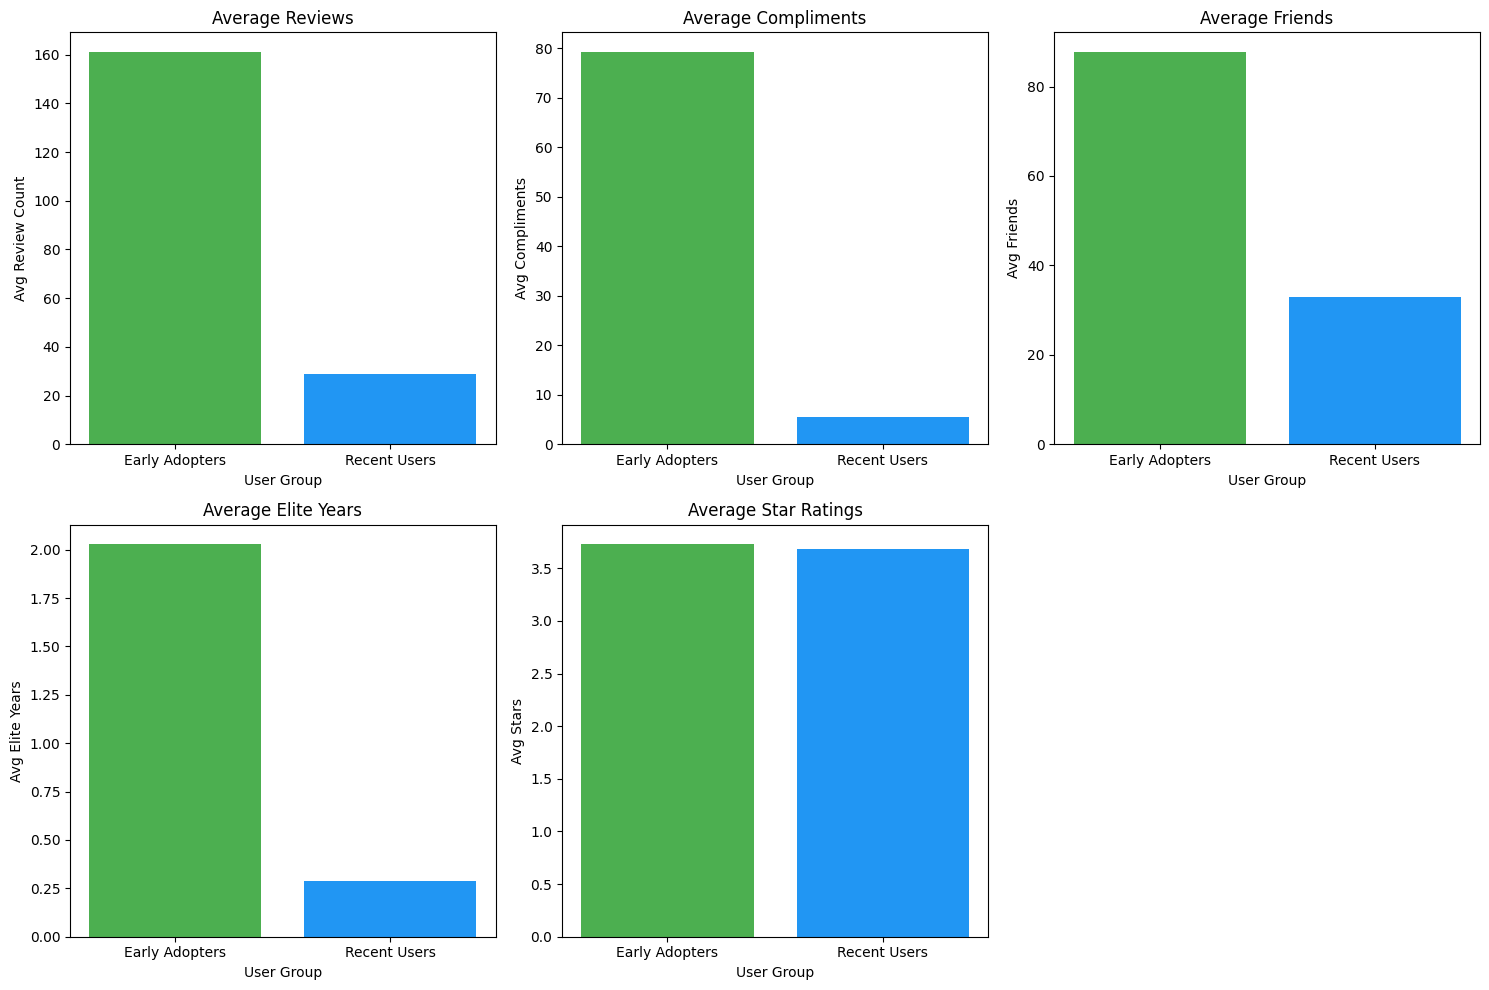

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics to plot
metrics = ['avg_review_count', 'avg_compliments', 'avg_friends', 'avg_elite_years', 'avg_stars']
titles = ['Average Reviews', 'Average Compliments', 'Average Friends', 'Average Elite Years', 'Average Star Ratings']
user_groups = result_df['user_group']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Plot each metric
for i, metric in enumerate(metrics):
    axes[i].bar(user_groups, result_df[metric], color=['#4CAF50', '#2196F3'])
    axes[i].set_title(titles[i])
    axes[i].set_ylabel(metric.replace('_', ' ').title())
    axes[i].set_xlabel('User Group')

# Hide the extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

What's interesting to note from our analysis is that, despite the vast majority of users being Recent Users, there seems to be a shift in attitude towards rating culture.

While both groups are almost comparable in terms of Average Star Ratings, there is a large gap in every other sector. We could potentially correlate this to the advent of smartphones, but that's an analysis for another time.

However, it would be interesting to understanding if any of these other factors have a hand in influencing star ratings.

<h3>Analysis 2</h3>
<h5>Correlation between Average Stars, Social Influence, and Elite Tenure</h5>

Let's build a correlation matrix to understand how much influence these other factors have over star ratings.

Correlation Matrix:
                  average_stars  elite_year_count  social_influence
average_stars          1.000000          0.044260          0.019008
elite_year_count       0.044260          1.000000          0.764125
social_influence       0.019008          0.764125          1.000000


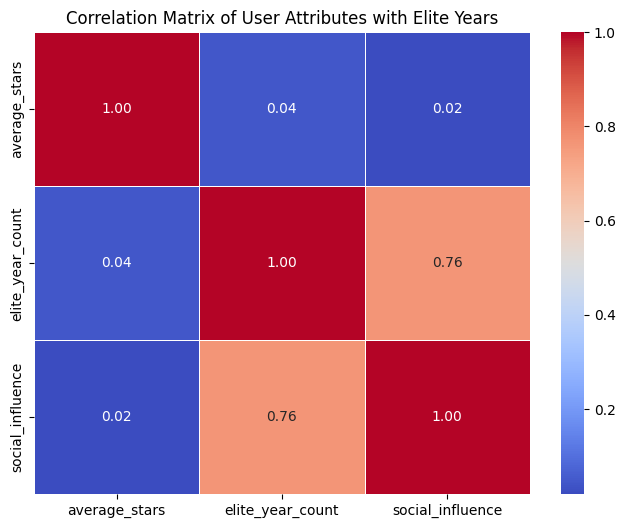

In [68]:
# Import necessary libraries
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns for correlation analysis
user_influence_df = spark.sql("""
    SELECT average_stars, elite_year_count, 
           (fans + compliment_total) AS social_influence
    FROM az_funeral_users
""")

# Collect the data into a Pandas DataFrame
user_influence_df_pd = user_influence_df.toPandas()

# Compute the correlation matrix
correlation_matrix = user_influence_df_pd.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of User Attributes with Elite Years")
plt.show()

Given that Yelp isn't a social networking website but meant for reviewing and researching services and businesses, it makes complete sense that the influence of social connections (like fans and friends) is almost negligible in our category.

Elite years on the other hand, seem to have a fairly high positive correlation. This is in line with our understanding of the Elite status on Yelp.

Elite users are recognized by the Yelp community for being trustworthy and reliable users who have made significant contributions to the community. It's only understandable that they are more likely to provide genuine ratings.

<h3>Analysis 3</h3>
<h5>Comparison of Elite and Non-Elite User Activity</h5>

Since we've identified that Elite status has some significance in average star ratings, let's see if we can draw parallels between the behavior of Elite users and regular users.

In [69]:
elite_status_df = spark.sql("""
SELECT 
    CASE 
        WHEN elite_year_count > 0 THEN 'Elite' 
        ELSE 'Non-Elite' 
    END AS elite_status,
    COUNT(user_id) AS user_count,
    AVG(review_count) AS avg_review_count,
    AVG(fans) AS avg_fans,
    AVG(compliment_total) AS avg_compliments,
    AVG(average_stars) AS avg_rating
FROM az_funeral_users
GROUP BY elite_status
ORDER BY elite_status DESC
""")
elite_status_df.show()

+------------+----------+------------------+-------------------+------------------+------------------+
|elite_status|user_count|  avg_review_count|           avg_fans|   avg_compliments|        avg_rating|
+------------+----------+------------------+-------------------+------------------+------------------+
|   Non-Elite|       167|22.940119760479043|0.47904191616766467|1.6347305389221556|3.6644311377245504|
|       Elite|        23| 283.7826086956522|  19.73913043478261| 151.7826086956522|3.8839130434782607|
+------------+----------+------------------+-------------------+------------------+------------------+



In [70]:
elite_status_pd = elite_status_df.toPandas()

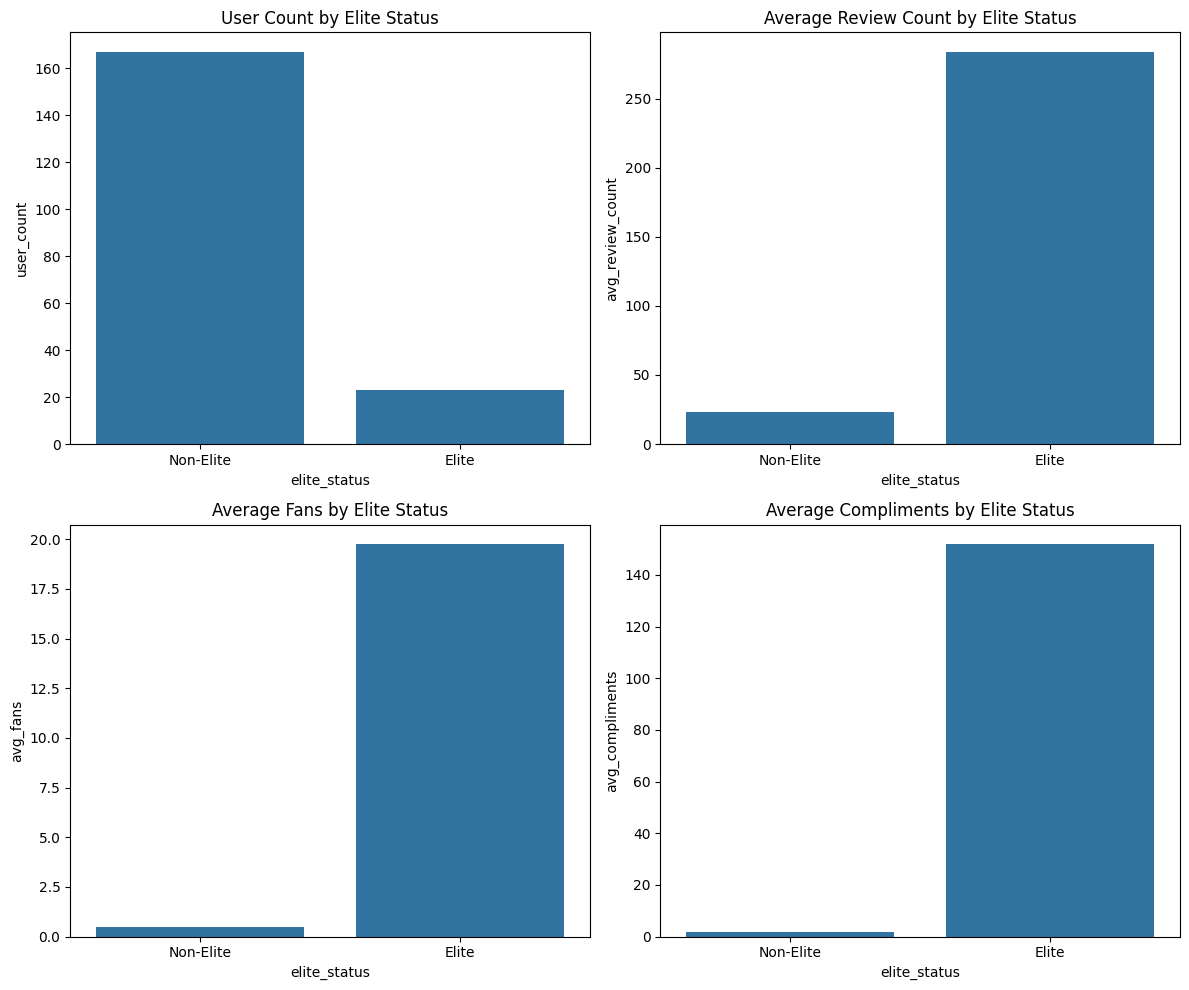

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a subplot with multiple charts
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot user count
sns.barplot(x='elite_status', y='user_count', data=elite_status_pd, ax=axes[0, 0])
axes[0, 0].set_title('User Count by Elite Status')

# Plot average review count
sns.barplot(x='elite_status', y='avg_review_count', data=elite_status_pd, ax=axes[0, 1])
axes[0, 1].set_title('Average Review Count by Elite Status')

# Plot average fans
sns.barplot(x='elite_status', y='avg_fans', data=elite_status_pd, ax=axes[1, 0])
axes[1, 0].set_title('Average Fans by Elite Status')

# Plot average compliments
sns.barplot(x='elite_status', y='avg_compliments', data=elite_status_pd, ax=axes[1, 1])
axes[1, 1].set_title('Average Compliments by Elite Status')

plt.tight_layout()
plt.show()

Despite their low volume, Elite users on average have more fans, compliments, and reviews than their Non-Elite peers.
It goes to show that Elite status is definitely worth considering when choosing a business.

<h3>Analysis 4</h3>
<h5>Sentiment Analysis of User Reviews</h5>

Now that we know Elite users are a strong deciding factor to consider a business, let's look at the content of reviews themselves.

Granted the nature of 'Funeral Services & Cemeteries' being emotional, would it be a reach to infer that user reviews are also going to echo the same sentiments?

Only way to find out is by analyzing our review data.

In [72]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [73]:
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to classify sentiment
def classify_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return "Emotional"
    elif sentiment_score['compound'] <= -0.05:
        return "Functional"
    else:
        return "Neutral"

# Register the function as a UDF
sentiment_udf = udf(classify_sentiment, StringType())

In [74]:
# Load the az_funeral_reviews view
reviews_df = spark.sql("SELECT * FROM az_funeral_reviews")

# Apply the UDF to classify sentiment
reviews_with_sentiment = reviews_df.withColumn("sentiment", sentiment_udf(reviews_df["text"]))

# Create a temporary view for Spark SQL analysis
reviews_with_sentiment.createOrReplaceTempView("reviews_with_sentiment")

In [75]:
# Analyze sentiment distribution
sentiment_distribution = spark.sql("""
    SELECT sentiment, COUNT(*) AS review_count
    FROM reviews_with_sentiment
    GROUP BY sentiment
    ORDER BY review_count DESC
""")

# Show the results
sentiment_distribution.show()

+----------+------------+
| sentiment|review_count|
+----------+------------+
| Emotional|         143|
|Functional|          42|
|   Neutral|           5|
+----------+------------+



In [76]:
# Convert to Pandas DataFrame
sentiment_distribution_pd = sentiment_distribution.toPandas()

/tmp/ipykernel_5536/2745940622.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_distribution_pd, x="sentiment", y="review_count", palette="Set2")


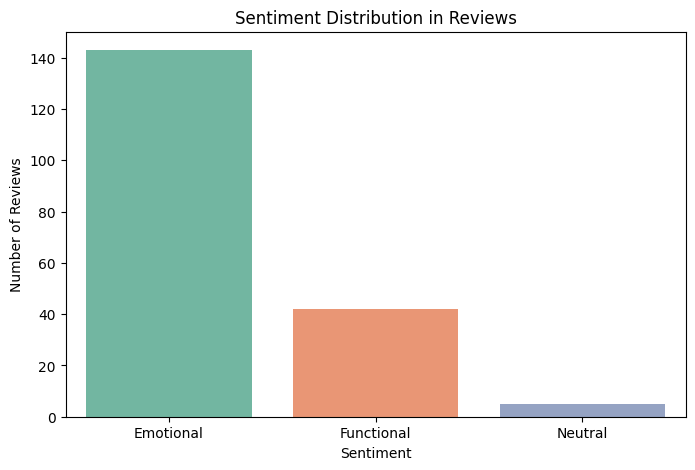

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_distribution_pd, x="sentiment", y="review_count", palette="Set2")
plt.title("Sentiment Distribution in Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Emotional reviews significantly outweigh Functional and Neutral ones. This, is in agreement with the assumptions we've made from our previous milestone: human emotion is very tighly coupled with the 'Funeral Services & Cemeteries' businesses.

But on average, are there any patterns between how well businesses are received and the ratings left by users?

<h3>Analysis 5</h3>
<h5>Analyzing the Relationship Between Sentiment Scores and Average Ratings</h5>

Let's see how sentiment scores from our reviews are distributed against the average ratings given by users.

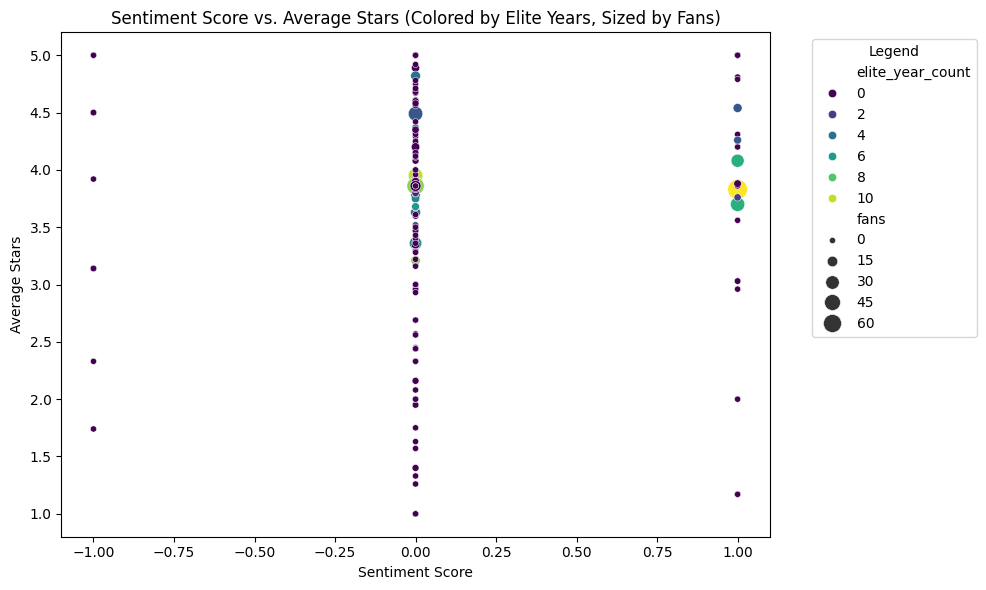

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Sentiment Scores in Spark SQL
sentiment_scores_query = """
    WITH sentiment_scores AS (
        SELECT 
            user_id,
            SUM(CASE WHEN LOWER(text) LIKE '%good%' OR LOWER(text) LIKE '%excellent%' THEN 1 ELSE 0 END) -
            SUM(CASE WHEN LOWER(text) LIKE '%bad%' OR LOWER(text) LIKE '%poor%' THEN 1 ELSE 0 END) AS sentiment_score
        FROM az_funeral_reviews
        GROUP BY user_id
    )
    SELECT
        s.user_id,
        s.sentiment_score,
        u.average_stars,
        u.elite_year_count,
        u.fans
    FROM sentiment_scores s
    INNER JOIN az_funeral_users u
        ON s.user_id = u.user_id
"""

# Execute the query
user_sentiment_df = spark.sql(sentiment_scores_query)

# Convert Spark DataFrame to Pandas for Visualization
scatter_data = user_sentiment_df.toPandas()

# Create the Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=scatter_data,
    x="sentiment_score",
    y="average_stars",
    hue="elite_year_count",
    size="fans",
    sizes=(20, 200),
    palette="viridis"
)
plt.title("Sentiment Score vs. Average Stars (Colored by Elite Years, Sized by Fans)")
plt.xlabel("Sentiment Score")
plt.ylabel("Average Stars")
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

From our analysis, we can identify that a positive sentiment score seems to have a strong correlation with average star ratings being high. While fans don't show any impact, Elite years also seem to indicate a degree of influence.

<h3>Analysis 6</h3>
<h5>Check In Activity of Elite Users</h5>

For all the positives that Elite users bring to a business' performance, are they physically interacting with these establishments as well? Let's see if we can infer anything from their check-in behavior.

In [81]:
spark.sql("""
    SELECT 
        c.business_id,
        c.total_checkins,
        COUNT(u.user_id) AS elite_user_count,
        COUNT(u.user_id) * 100 / c.total_checkins AS percentage_of_elite_users
    FROM az_funeral_users u
    JOIN (
        SELECT business_id, COUNT(*) AS total_checkins
        FROM (
            SELECT business_id, EXPLODE(SPLIT(date, ',')) AS checkin_date
            FROM az_funeral_checkins
        )
        GROUP BY business_id
    ) c
    ON u.review_business_id = c.business_id
    WHERE u.elite_year_count > 0
    GROUP BY c.business_id, c.total_checkins
    ORDER BY c.total_checkins DESC
""").show(truncate=False)

+----------------------+--------------+----------------+-------------------------+
|business_id           |total_checkins|elite_user_count|percentage_of_elite_users|
+----------------------+--------------+----------------+-------------------------+
|QJiwt95fIzDhIIJ24Jq77A|23            |1               |4.3478260869565215       |
|8HA0FczzYJSHA6mj25-5-Q|15            |3               |20.0                     |
|ojE9oIuCmzx8emPgtD0GQA|9             |1               |11.11111111111111        |
|ayvHmWGyyD8b3hjjiZ2vNA|8             |6               |75.0                     |
|8tZYMBerdaI3ctzFWlgOcQ|5             |4               |80.0                     |
|NAVL2KEVWpZCirAb_LwJBw|4             |3               |75.0                     |
|S0W6HvaAthTIBT2IE80nDQ|4             |2               |50.0                     |
+----------------------+--------------+----------------+-------------------------+



Although businesses with high checkins haven't seen a lot of footfall from Elite users, it is interesting to observe that for the limited data available in our category, Elite users do make up a significant percentage of visitors per business.

<h3>Analysis 7</h3>
<h5>Average Checkins by User Group</h5>

Let's drill further down to see if there are any more nuances to the tenure of Elite status on average checkins. 

In [82]:
# Running the query and collecting the result into a Pandas DataFrame
result = spark.sql("""
    SELECT 
        u.elite_year_count, 
        AVG(c.total_checkins) AS avg_checkins
    FROM az_funeral_users u
    JOIN (
        SELECT business_id, COUNT(*) AS total_checkins
        FROM (
            SELECT business_id, EXPLODE(SPLIT(date, ',')) AS checkin_date
            FROM az_funeral_checkins
        )
        GROUP BY business_id
    ) c
    ON u.review_business_id = c.business_id
    GROUP BY u.elite_year_count
    ORDER BY u.elite_year_count
""").toPandas()


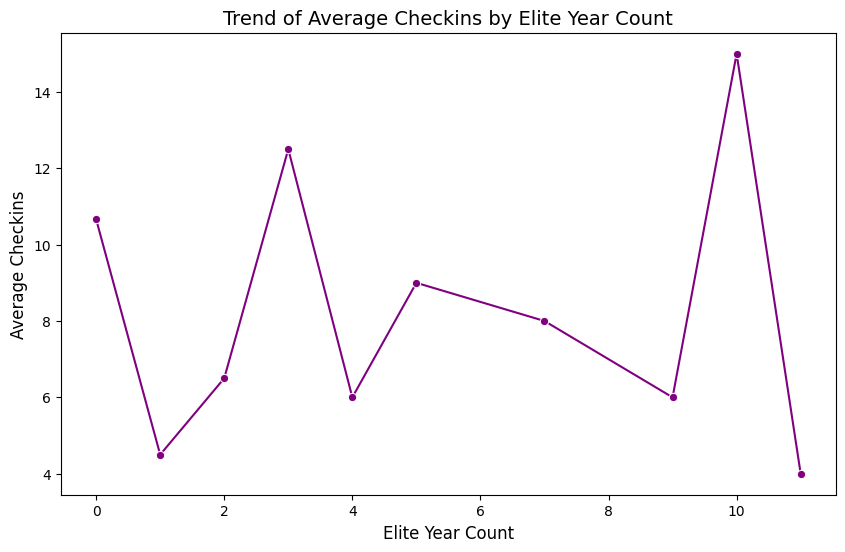

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Create a line plot to show the trend of avg_checkins by elite_year_count
plt.figure(figsize=(10,6))
sns.lineplot(x='elite_year_count', y='avg_checkins', data=result, marker='o', color='purple')

# Adding titles and labels
plt.title('Trend of Average Checkins by Elite Year Count', fontsize=14)
plt.xlabel('Elite Year Count', fontsize=12)
plt.ylabel('Average Checkins', fontsize=12)

# Show the plot
plt.show()

From this analysis, we can't really establish a clear relationship between average checkins and the number of years a user has been Elite.

Although this could vary for different business categories, 'Funeral Services & Cemeteries' does not seem to show any relationship. So we can just limit our inference to the fact that Elite users do end up contributing to business checkins.

<h3>Analysis 8</h3>
<h5>Tip Activity and Usefulness</h5>

Another interesting metric to explore is the Useful attribute. Reviews are usually rated as useful by other users when it contains some relevant information that others may want to know before visiting or undertaking services.

Tips are a different type of feedback users provide, as they are usually just quick suggestions. 

Let's see if users who often receive a 'Useful' vote also leave tips on those businesses.

In [59]:
spark.sql("""SELECT 
    u.user_id,
    u.review_count,
    u.useful AS useful_votes,
    COUNT(t.business_id) AS total_tips
FROM az_funeral_users u
LEFT JOIN az_funeral_tips t 
    ON u.user_id = t.user_id 
    AND u.review_business_id = t.business_id
GROUP BY u.user_id, u.review_count, u.useful
ORDER BY total_tips DESC""").show()

+--------------------+------------+------------+----------+
|             user_id|review_count|useful_votes|total_tips|
+--------------------+------------+------------+----------+
|TPYOWMwLyRaVAYD4I...|          69|          71|         0|
|GebsEZuGAnqhmJfu3...|           3|           0|         0|
|2ihI3eX7xLJVRTxs6...|          20|          13|         0|
|fYz2voIxcCk5W3Af6...|          86|         286|         0|
|vR_D58KzWTayS_KQ1...|          19|          13|         0|
|rSCPsVsGR7YOgxTlV...|          55|         122|         0|
|OQerWl0RK9pC8rPBU...|           3|           0|         0|
|YVm3-xWMcNEPmfjfE...|          13|           6|         0|
|QWl2hTzE6hI2rXhdw...|           9|           9|         0|
|XkSW630DDjmq8TIN-...|          19|          17|         0|
|A2rODEDsfYOUt-HbS...|          12|          13|         0|
|Q8TMv0Tm5T0pDfn-2...|          42|          98|         0|
|Yz83gop_P1JeQ2InA...|          10|           3|         0|
|hf18bsEwDcKigNvTE...|          32|     

Unfortunately, users with 'useful' votes on their reviews are mostly not leaving tips on businesses they review.

<h3>Analysis 9</h3>
<h5>Do Positively Incentivized Users Tip More Often?</h5>

Let's try looking at this from a different angle.

Giving a 'useful' vote tends to be about the review in itself; while compliments are more tied to a user's status and how they are viewed by the community.

If we look at compliments as an incentive for users, could it be that users with compliments are more likely to go the additional mile and leave tips for the community?

In [87]:
result_df = spark.sql("""SELECT 
    u.user_id,
    u.compliment_total AS compliments_received,
    COUNT(t.business_id) AS total_tips
FROM az_funeral_users u
LEFT JOIN az_funeral_tips t ON u.user_id = t.user_id
GROUP BY u.user_id, u.compliment_total
ORDER BY total_tips DESC""")
result_df.show()

+--------------------+--------------------+----------+
|             user_id|compliments_received|total_tips|
+--------------------+--------------------+----------+
|0yrF14nWVAFeI0fG2...|                 179|        72|
|1viszljzsa8W7VnYP...|                 165|        54|
|PAc93PtEbYDtytBQ9...|                 222|        49|
|DB5uuOamJ5N2RZ5yl...|                  53|        48|
|Js1FsZ6oP_9tO5tbJ...|                 535|        32|
|mmSvRe11vbz3XTXw5...|                  51|        26|
|3_iu3Mh30tNU7BcKW...|                  77|        25|
|9GggL0-O_Moi62c5L...|                 119|        21|
|ihRfguL7gXzgCGE5x...|                   2|        11|
|61oNX0ncwBCq0n3jg...|                  20|        10|
|oNrK5S4U-87_hrgwD...|                   1|        10|
|TPYOWMwLyRaVAYD4I...|                   5|         9|
|b27nK27X63h7-3i61...|                   1|         4|
|-P7QbuJKBALJYH2_c...|                  53|         4|
|fYz2voIxcCk5W3Af6...|                  49|         4|
|6fJNAIIlk

In [88]:
# Convert the Spark DataFrame to Pandas for visualization
pandas_df = result_df.toPandas()

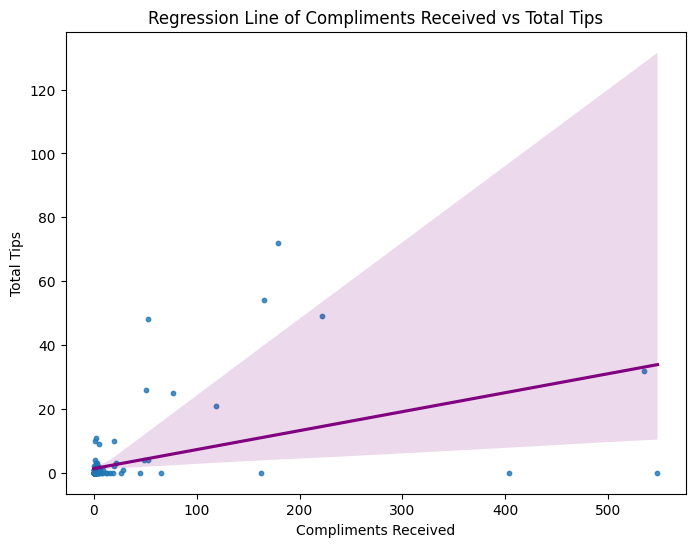

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.regplot(x='compliments_received', y='total_tips', data=pandas_df, scatter_kws={'s': 10}, line_kws={'color': 'purple'})

# Add title and labels
plt.title('Regression Line of Compliments Received vs Total Tips')
plt.xlabel('Compliments Received')
plt.ylabel('Total Tips')

plt.show()

From our regression line, we can establish that there does seem to be some relationship between tips and compliments received by a user. Therefore, we can surmise that users who are positively incentivized tend to leave more compliments than their peers.

<h3>Analysis 10</h3>
<h5>Are Users Tipping More When They Have Friends?<h5>

Since we've established that positive incentives like compliments are more likely to influence a user's tip behavior, does the same apply to their social behaviors on the platform?

Could a positive social perception among peers be a strong enough influence for users to leave more tips?

In [74]:
spark.sql("""SELECT 
    CASE 
        WHEN u.friend_count BETWEEN 0 AND 10 THEN '0-10'
        WHEN u.friend_count BETWEEN 11 AND 50 THEN '11-50'
        WHEN u.friend_count BETWEEN 51 AND 100 THEN '51-100'
        ELSE '100+' 
    END AS friend_group,
    COUNT(t.business_id) AS total_tips
FROM az_funeral_users u
LEFT JOIN az_funeral_tips t ON u.user_id = t.user_id
GROUP BY friend_group
ORDER BY total_tips DESC;""").show()

+------------+----------+
|friend_group|total_tips|
+------------+----------+
|      51-100|       163|
|        100+|       152|
|       11-50|        79|
|        0-10|        21|
+------------+----------+



As we can see, the more friends a user has, the more often they leave tips.

<h3>Conclusion</h3>

We can see that humans at their core are inherently social and emotional creatures. These aspects can exert their influence in business success, especially in a business category that is 'Funeral Services & Cemeteries'.

As the platform grows, Yelp will have more users signing up and participating. Reviews for this category are predominantly emotional; which is in line with the nature of occasions that require their services.

Elite Status, a symbol of tenure and contribution, gives users a sense of trust in judgement. They take decisions with confidence, as these Elite users seem to be strongly involved in their communities.

Regardless of status however, users are bound to contribute more when they are the subject of appreciation; rather than their reviews. Everyone can leave a review. But tips are only left by those with positive incentives.